In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import datetime
import matplotlib.pyplot as plt
from sklearn.covariance import LedoitWolf
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')

# 1 Get data

## 1.1 Get utilities in S&P data

In [2]:
# Pull the list of utility stock tickers from wikepedia
# store them in utlilities tickers
import requests
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
response = requests.get(url)
text = response.text
from bs4 import BeautifulSoup
soup = BeautifulSoup(text)
tag_list = soup.find_all("tr")
utilities_tickers = list()
for tag in tag_list:
    try:
        if tag.find_all('td')[2].get_text() == 'Utilities':
            utilities_tickers.append(tag.find_all('td')[0].get_text().replace("\n", ""))        
    except IndexError:
        pass

In [3]:
import datetime as dt
from pandas_datareader import data as pdr
import yfinance as yfin

yfin.pdr_override()

start_date = dt.datetime(1960, 1, 1)
end_date = dt.datetime(2023, 1, 1)

utilities_stock_data = dict()

for ticker in utilities_tickers:
    df = pdr.get_data_yahoo(ticker, start=start_date, end=end_date)
    df = df.reset_index()
    df['Date'] =  pd.to_datetime(df['Date'])
    utilities_stock_data[ticker] = df

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [4]:
monthly_spy_data = pd.read_csv('./SPY.csv', index_col='Date', parse_dates=True)
monthly_spy_data['Monthly_Return'] = monthly_spy_data['Adj Close'].pct_change(periods=1)
monthly_spy_data.index = monthly_spy_data.index - pd.DateOffset(days=1)
monthly_spy_data = monthly_spy_data.drop(monthly_spy_data.tail(5).index)
monthly_spy_data

,Open,High,Low,Close,Adj Close,Volume,Monthly_Return
Date,,,,,,,
1993-01-31,43.968750,45.125000,42.812500,44.406250,25.390364,5417600,NaN
1993-02-28,44.562500,45.843750,44.218750,45.187500,25.837070,3019200,0.017594
1993-03-31,45.250000,45.250000,43.281250,44.031250,25.294857,2697200,-0.020986
1993-04-30,44.093750,45.656250,43.843750,45.218750,25.977036,1808000,0.026969
1993-05-31,45.375000,45.812500,44.218750,45.062500,25.887280,3438000,-0.003455
...,...,...,...,...,...,...,...
2022-08-31,392.890015,411.730011,357.040009,357.179993,352.746490,1998908600,-0.096159
2022-09-30,361.079987,389.519989,348.109985,386.209991,382.982941,2024732000,0.085717
2022-10-31,390.140015,407.679993,368.790009,407.679993,404.273560,1745985300,0.055592


In [5]:
# utilities data
for ticker in utilities_stock_data:
    utilities_stock_data[ticker]= utilities_stock_data[ticker].set_index('Date')
    utilities_stock_data[ticker] = utilities_stock_data[ticker].resample('M').last()
    utilities_stock_data[ticker]['pct change'] = utilities_stock_data[ticker]['Adj Close'].pct_change()

In [6]:
pop = ['AES', 'AEE', 'CEG', 'AWK', 'CMS', 'FE', 'NRG', 'SRE'] # cutoff around ~400 months of data
for p in pop: 
    utilities_stock_data.pop(p)

In [7]:
# store data in dataframe
data = {}
for ticker in utilities_stock_data:
    data[ticker] = utilities_stock_data[ticker]['pct change']
utilities_returns = pd.DataFrame(data)
utilities_returns = utilities_returns.set_index(utilities_stock_data['AEP'].index)
utilities_returns = utilities_returns.iloc[1: , :]
utilities_returns = utilities_returns.dropna()
utilities_returns

,LNT,AEP,ATO,CNP,ED,D,DTE,DUK,EIX,ETR,...,EXC,NEE,NI,PCG,PNW,PPL,PEG,SO,WEC,XEL
Date,,,,,,,,,,,,,,,,,,,,,
1984-01-31,0.000000,0.072993,0.000000,0.032258,0.010100,0.067796,0.018182,-0.009950,-0.025158,0.009346,...,0.043479,-0.009317,-0.034188,0.008404,-0.006451,0.042425,0.027473,-0.003138,0.004546,-0.026316
1984-02-29,-0.035088,-0.052498,0.022556,-0.028245,-0.070189,-0.095238,0.000000,-0.068241,-0.054838,0.037037,...,-0.012878,-0.065570,-0.008849,-0.075000,-0.019481,0.005814,-0.083844,-0.055118,-0.072398,-0.027027
1984-03-31,-0.059091,-0.029630,0.029412,0.019868,0.054945,0.011695,-0.051107,0.060773,-0.004814,-0.032157,...,0.008772,0.020619,-0.017858,-0.043466,-0.046358,-0.057804,-0.012050,0.025000,0.014634,-0.031250
1984-04-30,0.019323,0.007634,-0.057143,0.025974,0.031250,0.080926,-0.058253,-0.015625,0.056338,-0.057142,...,-0.104347,0.026936,0.000000,0.029126,-0.104166,0.018405,0.085367,0.008130,0.028846,0.025089
1984-05-31,0.004740,-0.019454,0.000000,-0.026792,0.016500,-0.069519,0.041238,-0.002049,-0.033334,0.020201,...,-0.008135,-0.034740,-0.063636,0.018868,0.062015,0.054217,-0.028090,-0.036545,0.009346,0.024475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-31,0.001805,0.024625,-0.060576,0.000436,-0.007595,-0.002196,0.000307,-0.018510,0.000000,0.009997,...,-0.048458,0.011629,-0.029276,0.135359,0.025589,0.000000,-0.019948,0.011168,0.000471,0.014621
2022-09-30,-0.131881,-0.137225,-0.101693,-0.106248,-0.122570,-0.148178,-0.111286,-0.129922,-0.155475,-0.127233,...,-0.146891,-0.078180,-0.146391,0.013788,-0.143862,-0.121587,-0.119246,-0.117685,-0.132926,-0.132408
2022-10-31,-0.007126,0.017004,0.046146,0.015259,0.025653,0.012444,-0.025554,0.001720,0.061152,0.064692,...,0.030166,-0.011606,0.029384,0.194400,0.055218,0.044970,-0.002845,-0.037059,0.021246,0.017344


Original attempt was to create custom market factors for within the S&P universe. After extensive searching it was found impossible to collect the data required without paying for a service. Therefore an alternative method of evaluating the factor model was required. 

* Chose to implement Asness and Frazzini's HML calculation, and see how it performs not just in 5 factor (as in their literature) but also for 3 factor and 6 factor

Exploring the difference between Fama French factors vs Asness and Frazzini factors as explained in Asness, C.S, and Frazzini, A. (2013), The Devil in HML’s Details. 

Information on paper can be found: `https://www.aqr.com/Insights/Research/Journal-Article/The-Devil-in-HMLs-Details`

Paper can be found: `https://www.iijournalseprint.com/JPM/AQR/Sum13DevilinHMLsDetails05t/index.html`

Data can be found: `https://www.aqr.com/Insights/Datasets/The-Devil-in-HMLs-Details-Factors-Monthly`

The Journal of Portfolio Management, Vol. 39, No. 4, pp. 49-68

## 1.2 Get factor data

In [8]:
factor_df = pd.read_csv('./factor_FF_devil.csv', index_col=0)
factor_df.index = pd.to_datetime(factor_df.index, format='%Y%m') + datetime.timedelta(days=-1)
factor_df['HML devil'] = factor_df['HML devil']*100
factor_df = factor_df/100
factor_df

,MKT,SMB,HML FF,HML devil,RMW,CMA,RF,MOM,STR
Date,,,,,,,,,
1963-06-30,-0.0039,-0.0041,-0.0097,-0.0059,0.0068,-0.0118,0.0027,0.0090,-0.0008
1963-07-31,0.0507,-0.0080,0.0180,0.0028,0.0036,-0.0035,0.0025,0.0101,0.0130
1963-08-31,-0.0157,-0.0052,0.0013,0.0027,-0.0071,0.0029,0.0027,0.0019,0.0119
1963-09-30,0.0253,-0.0139,-0.0010,-0.0211,0.0280,-0.0201,0.0029,0.0312,-0.0066
1963-10-31,-0.0085,-0.0088,0.0175,0.0091,-0.0051,0.0224,0.0027,-0.0074,0.0112
...,...,...,...,...,...,...,...,...,...
2022-08-31,-0.0935,-0.0097,0.0006,-0.0274,-0.0151,-0.0084,0.0019,0.0347,-0.0161
2022-09-30,0.0783,0.0186,0.0805,0.0502,0.0307,0.0652,0.0023,0.0387,0.0033
2022-10-31,0.0460,-0.0267,0.0138,0.0241,0.0601,0.0311,0.0029,-0.0201,0.0055


# 2 Allocation Methods

## 2.1 Mean-Variance

In [9]:
def sampleMeanVariant(sigmahat, muhat, rf, kappa):
    e = np.ones((sigmahat.shape[0], 1))
    H = (muhat - rf*e).T @ np.linalg.inv(sigmahat) @ (muhat - rf*e)
    aStar = (kappa-rf)/H * np.linalg.inv(sigmahat) @ (muhat - rf*e)
    return aStar

In [10]:
sampleMeanVariant(np.cov(utilities_returns, rowvar=False), np.array([np.mean(utilities_returns, axis=0)]).T, factor_df['RF'][-1], 0.012)

array([[ 0.01174689],
       [-0.16453482],
       [ 0.24406815],
       [-0.02552   ],
       [-0.13859146],
       [ 0.08812247],
       [ 0.1930962 ],
       [-0.01928378],
       [ 0.04250433],
       [-0.12286912],
       [-0.22672193],
       [-0.01627813],
       [ 0.00435758],
       [ 0.44437783],
       [-0.00123045],
       [-0.00887794],
       [-0.05948972],
       [-0.04751004],
       [ 0.01659171],
       [ 0.43326434],
       [ 0.21510392],
       [ 0.00996568]])

## 2.2 Method 1: Factor Model

In [33]:
def factorModel(returns, factorDF, rf, kappa, numFactors):
    """ 
    returns - monthly returns dataframe of each equity (m,d)
    factorDF - df of excess market returns, SMB, HML
    rf - series of rf rate
    kappa - targeted expected return for portfolio
    numFactors - the number of factors in the model
    """

    d = returns.shape[1]
    # Compute the excess returns of each asset
    excess_returns = returns.sub(rf,axis=0).values

    # Define arrays to store the beta coefficients and residual variances
    betas = np.zeros((d, numFactors))
    residual_variances = np.zeros((d))

    # Perform the OLS regression for each asset
    for i in range(d):
        # Extract the excess returns of the i-th asset
        excess_asset_returns = excess_returns[:,i]

        # Define the OLS model with the R-rf ~ MF-rf + SMB + HML
        model = sm.OLS(excess_asset_returns,
                       sm.add_constant(factorDF))

        # Fit the model and extract the regression coefficients and residuals
        results = model.fit()
        beta = results.params[1:]
        residuals = results.resid

        # Store the beta coefficients and residual variance for the i-th asset
        betas[i] = beta
        if numFactors != 6:
            residual_variances[i] = np.var(residuals, ddof=numFactors + 1)
        else:
            residual_variances[i] = np.var(residuals, ddof=numFactors)
        
    sigmaFactor = np.cov(factorDF.T)
    Dhat = np.diag(residual_variances)
    sigmahat = betas@sigmaFactor@betas.T + Dhat
    muhat = returns.mean().values.reshape((-1, 1))
    
    # pass most recent rf 
    return sampleMeanVariant(sigmahat, muhat, rf[-1], kappa)

In [12]:
AF_factorDF = factor_df[['MKT', 'SMB', 'HML devil']].loc['1/31/1984':'12/31/2022']
rf_DF = factor_df['RF'].loc['1/31/1984':'12/31/2022']
AF_a = factorModel(utilities_returns, AF_factorDF, rf_DF, kappa=.012,numFactors=3)
AF_a

array([[0.05654649],
       [0.05334952],
       [0.06741339],
       [0.03710127],
       [0.07089735],
       [0.0693274 ],
       [0.08302907],
       [0.05912096],
       [0.03889344],
       [0.04043521],
       [0.03750992],
       [0.05049439],
       [0.04955984],
       [0.08639322],
       [0.04019788],
       [0.01763947],
       [0.01730353],
       [0.04307185],
       [0.05566423],
       [0.08926311],
       [0.0903829 ],
       [0.04852106]])

In [13]:
FF_factorDF = factor_df[['MKT', 'SMB', 'HML FF']].loc['1/31/1984':'12/31/2022']
FF_a = factorModel(utilities_returns, FF_factorDF, rf_DF, kappa=.012, numFactors=3)
FF_a

array([[0.05600944],
       [0.05145663],
       [0.06533541],
       [0.03636788],
       [0.07341158],
       [0.06781267],
       [0.0818519 ],
       [0.05743162],
       [0.03332142],
       [0.03908477],
       [0.04074071],
       [0.04976128],
       [0.04944605],
       [0.08998021],
       [0.04390549],
       [0.01530908],
       [0.01856317],
       [0.04291209],
       [0.05801991],
       [0.08845232],
       [0.09077776],
       [0.05109328]])

## 2.3 Method 2: James-Stein with Ledoit Wolf

In [14]:
def stein_wolf(returns, rf, params):
    kappa = params[0]
    mu_hat = np.mean(returns, axis=0)
    sigma_hat = np.cov(returns, rowvar=False)
    e = np.ones(len(mu_hat))
    d = len(returns.columns)
    N = len(returns)
    
    mu_0 = ((mu_hat.T @ np.linalg.inv(sigma_hat) @ e)/(e.T @ np.linalg.inv(sigma_hat) @ e)) * e
    alpha = (d + 2) / (d + 2 + (N - d - 2) * ((mu_hat - mu_0).T @ np.linalg.inv(sigma_hat) @ (mu_hat - mu_0)))
    shrunk_mean = (alpha * mu_0) + ((1 - alpha) * mu_hat)
    
    cov = LedoitWolf().fit(returns)
    shrunk_var = cov.covariance_
    
    return sampleMeanVariant(shrunk_var, np.array([shrunk_mean]).T, rf[-1], kappa)

In [15]:
stein_wolf(utilities_returns, rf_DF, [0.012])

array([[ 0.1020764 ],
       [-0.14515375],
       [ 0.24536385],
       [-0.07190114],
       [ 0.04975982],
       [ 0.19516648],
       [ 0.14421392],
       [ 0.00491181],
       [ 0.04215456],
       [-0.11209976],
       [-0.02282003],
       [ 0.07205902],
       [ 0.01451382],
       [ 0.19992182],
       [ 0.03772798],
       [ 0.03049008],
       [-0.0444979 ],
       [ 0.04216722],
       [-0.04717259],
       [ 0.23621824],
       [ 0.18165991],
       [ 0.00605072]])

## 2.3 Benchmark: 1/n

In [16]:
def equal_weights(returns, rf, params):
    a = np.repeat(1/len(returns.columns), len(returns.columns))
    return a

In [17]:
equal_weights(utilities_returns, factor_df['RF'], [])

array([0.04545455, 0.04545455, 0.04545455, 0.04545455, 0.04545455,
       0.04545455, 0.04545455, 0.04545455, 0.04545455, 0.04545455,
       0.04545455, 0.04545455, 0.04545455, 0.04545455, 0.04545455,
       0.04545455, 0.04545455, 0.04545455, 0.04545455, 0.04545455,
       0.04545455, 0.04545455])

# 3 Rolling Window

In [18]:
def roll(d, M, T, returns, method, params):
    '''
    d: number of assets
    M: size of window in terms of months
    T: total number of periods
    returns: T x d dataframe of returns for d assets for T total periods
    method: function that computes allocation weights
    params: parameters needed for allocation method
    '''

    X = np.zeros(T-M)
    dates = pd.to_datetime(returns.index)
    Rf = np.zeros(T-M)
    
    for t in range(M,T):
        # get training and testing set
        start = dates[t-M]
        end = dates[t]
        R_train = returns.loc[start:end]
        R_test = returns.loc[end]
        rf = factor_df['RF'].loc[start:end]
        
        # get allocation weights
        a = method(R_train, rf, params)
    
        # get return of next period
        X[t-M], Rf[t-M] = a.T @ R_test + (1 - np.sum(a)) * rf[-1], rf[-1]
    
    return X, Rf

In [26]:
def roll_factor(d, M, T, returns, factors, k=0.012):
    '''
    d: number of assets
    M: size of window in terms of months
    T: total number of periods
    returns: T x d dataframe of returns for d assets for T total periods
    factors: factors to be used in factor model
    '''
       
    X = np.zeros(T-M)
    dates = pd.to_datetime(returns.index)
    Rf = np.zeros(T-M)

    for t in range(M,T):
        # get training and testing set
        start = dates[t-M]
        end = dates[t]
        R_train = returns.loc[start:end]
        R_test = returns.loc[end]
        rf = factor_df['RF'].loc[start:end]
        
        # get allocation weights
        a = factorModel(R_train, factor_df[factors].loc[start:end], rf, kappa=k, numFactors=len(factors))
    
        # get return of next period
        X[t-M], Rf[t-M] = a.T @ R_test + (1 - np.sum(a)) * rf[-1], rf[-1]

    return X, Rf

# 4 Simulation

In [20]:
d = len(utilities_returns.columns)
M_range = [6, 1*12, 2*12, 5*12] # 1, 2, 5, 8, 10, year windows
T = len(utilities_returns)
k = 0.012

In [21]:
def get_performance_metrics(X, Rf):
    risk_premium = X - Rf
    ORTN = np.mean(risk_premium)
    OSR = np.mean(risk_premium)/np.std(risk_premium)
    return [ORTN, OSR] # return, sharpe ratio

In [72]:
def get_performance_metrics_roll(X, rf, horizon):
    M = horizon * 12
    T = len(X)
    
    ORTN = np.zeros(T-M)
    OSR = np.zeros(T-M)
    
    for t in range(M,T):
        x = X[t-M:t] - rf[t-M:t]
        ORTN[t-M] = np.mean(x)
        OSR[t-M] = np.mean(x)/np.std(x)

    ORTN = np.mean(ORTN)
    OSR = np.mean(OSR)
    
    return ORTN, OSR # return, sharpe ratio

In [90]:
def compare_FF_devil(factors, horizon, plot_equal, plot_market, k=0.012):
    '''
    factors: a list of factors without HML
    horizon: investment horizon in terms of years
    '''
    
    FF_factors = factors.copy()
    FF_factors.append('HML FF')
    AF_factors = factors.copy()
    AF_factors.append('HML devil')
    rf = factor_df['RF'][-1]
    
    for m in M_range:
        # factor model
        FF, Rf_FF = roll_factor(d, m, T, utilities_returns, FF_factors, k)
        AF, Rf_AF = roll_factor(d, m, T, utilities_returns, AF_factors, k)

        # stein wolf
        SW, Rf_SW = roll(d, m, T, utilities_returns, stein_wolf, [k])
        
        # benchmark 1
        equal, Rf_EW = roll(d, m, T, utilities_returns, equal_weights, [])
        
        # benchmark 2
        market = np.concatenate((np.repeat(monthly_spy_data['Monthly_Return'].iloc[1],len(FF)-len(monthly_spy_data)+2), monthly_spy_data['Monthly_Return'].iloc[1:-1]))
        
        # rolling of rolling
        df = pd.DataFrame({'FF':FF, 
                           'AF':AF, 
                           'SW': SW,
                           'EW': equal,
                           'SP':market
                          })
        df = df.rolling(horizon * 12).mean()

        # performance metrics
        df_metrics = pd.DataFrame({'FF': get_performance_metrics_roll(FF, Rf_FF, horizon), 
                                  'AF': get_performance_metrics_roll(AF, Rf_AF, horizon),
                                  'Stein-Wolf': get_performance_metrics_roll(SW, Rf_SW, horizon),
                                  'Equal Weights': get_performance_metrics_roll(equal, Rf_EW, horizon), 
                                  'S&P 500': get_performance_metrics_roll(market, Rf_FF, horizon)
                                  },
                                  ['ORTN','OSR'])
        df_metrics = df_metrics.style.set_caption('Performance Metrics')
        display(df_metrics)
        
        # plotting
        plt.plot(utilities_returns.index[m:], df['FF'], label='FF ' + str(len(factors)+1) + '-Factor')
        plt.plot(utilities_returns.index[m:], df['AF'], label='AF ' + str(len(factors)+1) + '-Factor')
        plt.plot(utilities_returns.index[m:], df['SW'], label='Stein-Wolf')
        
        if plot_equal:
            plt.plot(utilities_returns.index[m:], df['EW'], label='BM: Equal Weights')
        if plot_market:
            plt.plot(utilities_returns.index[m:], df['SP'], label='BM: S&P 500')

        plt.suptitle('Avg. Monthly Return Over ' + str(horizon) + '-Year Investment from Utilities Stocks in the S&P 500')
        plt.title('Rolling Window of Size ' + str(m) + ' Months')
        plt.legend()
        plt.ylabel('Return')
        plt.xlabel('End of ' + str(horizon) + '-year Investment')
        plt.show()

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009207,0.009407,0.009356,0.007361,0.007252
OSR,1.543962,1.670231,2.697968,0.181855,0.250459


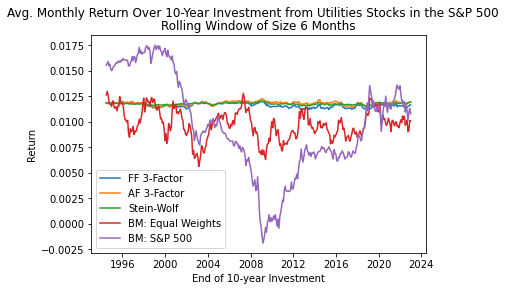

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009484,0.009479,0.009666,0.007358,0.007188
OSR,0.810176,0.799571,1.602700,0.181720,0.237584


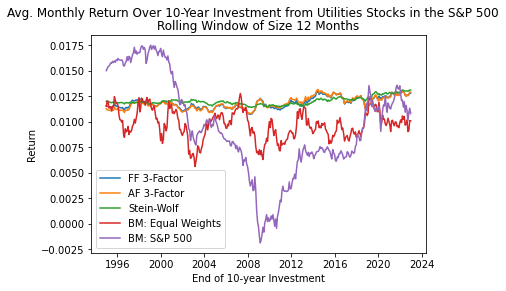

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.008039,0.007987,0.020159,0.007368,0.007045
OSR,0.419690,0.424684,0.496313,0.181807,0.215965


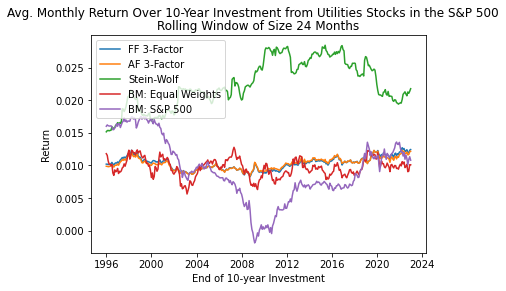

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009864,0.009949,0.019977,0.007522,0.006421
OSR,0.281276,0.283654,0.549213,0.183563,0.163688


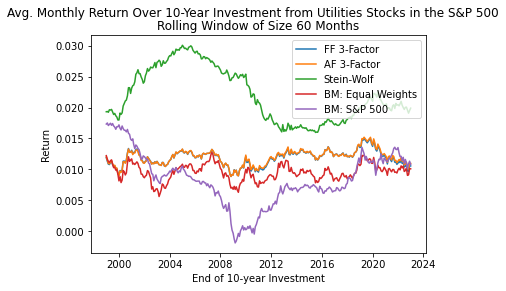

In [91]:
# 3 factor with BM
compare_FF_devil(['MKT','SMB'], 10, 1, 1, 0.0117)

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009207,0.009407,0.009356,0.007361,0.007252
OSR,1.543962,1.670231,2.697968,0.181855,0.250459


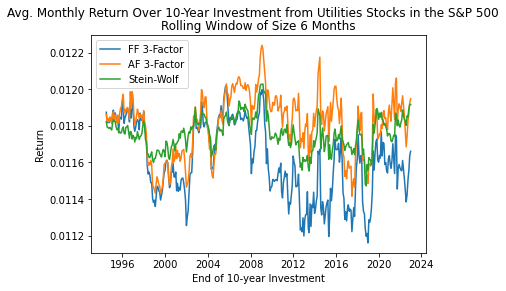

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009484,0.009479,0.009666,0.007358,0.007188
OSR,0.810176,0.799571,1.602700,0.181720,0.237584


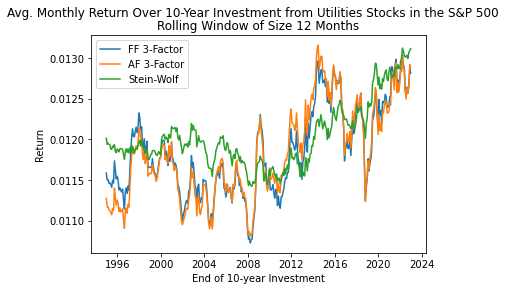

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.008039,0.007987,0.020159,0.007368,0.007045
OSR,0.419690,0.424684,0.496313,0.181807,0.215965


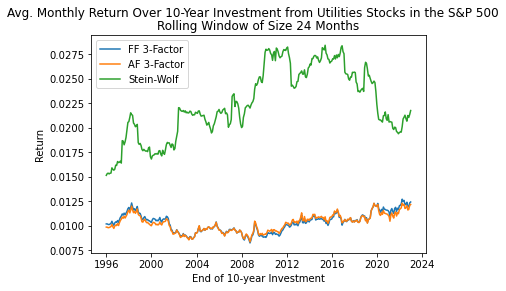

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009864,0.009949,0.019977,0.007522,0.006421
OSR,0.281276,0.283654,0.549213,0.183563,0.163688


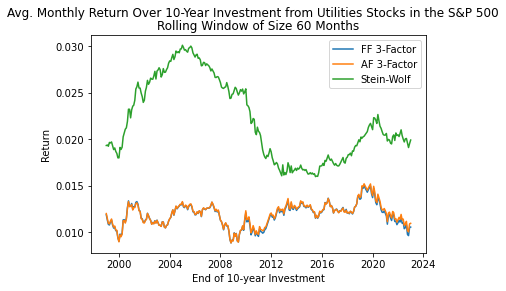

In [92]:
# 3 factor w/o BM
compare_FF_devil(['MKT','SMB'], 10, 0, 0, 0.0117)

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009219,0.009321,0.009356,0.007361,0.007252
OSR,2.333197,2.432390,2.697968,0.181855,0.250459


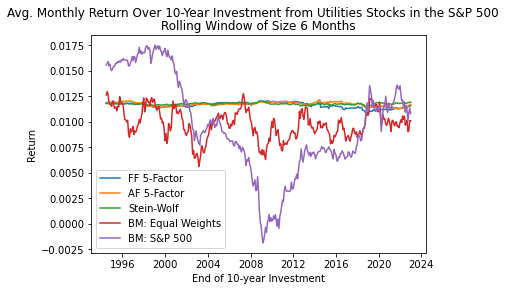

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009314,0.009296,0.009666,0.007358,0.007188
OSR,0.918838,0.912382,1.602700,0.181720,0.237584


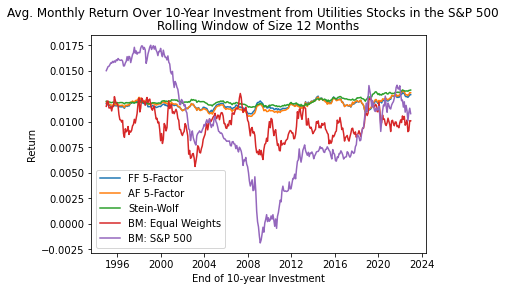

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.008093,0.008105,0.020159,0.007368,0.007045
OSR,0.462210,0.467063,0.496313,0.181807,0.215965


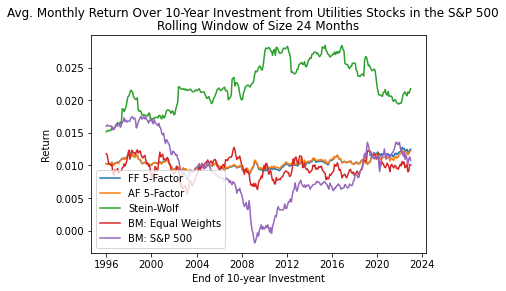

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.010031,0.010008,0.019977,0.007522,0.006421
OSR,0.295535,0.296219,0.549213,0.183563,0.163688


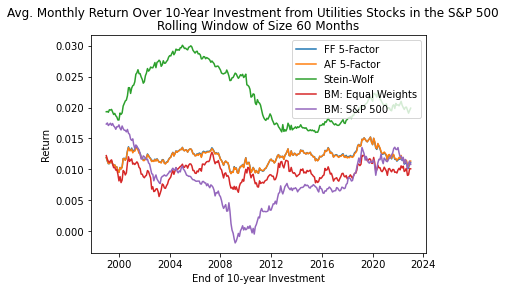

In [93]:
# ff 5-factor with BM
compare_FF_devil(['MKT','SMB','RMW','CMA'], 10, 1, 1, 0.0117)

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009219,0.009321,0.009356,0.007361,0.007252
OSR,2.333197,2.432390,2.697968,0.181855,0.250459


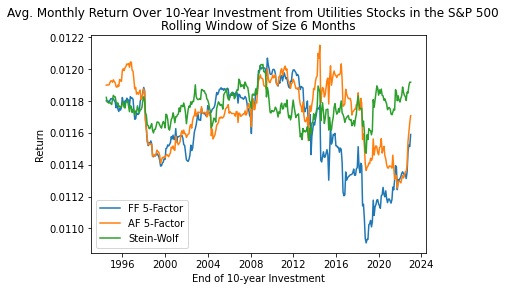

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009314,0.009296,0.009666,0.007358,0.007188
OSR,0.918838,0.912382,1.602700,0.181720,0.237584


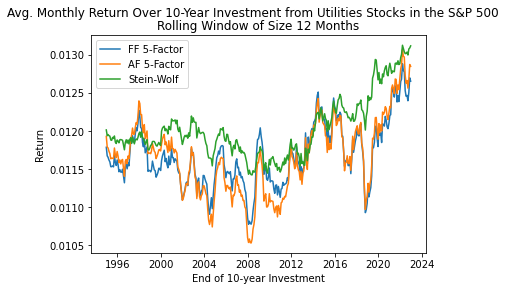

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.008093,0.008105,0.020159,0.007368,0.007045
OSR,0.462210,0.467063,0.496313,0.181807,0.215965


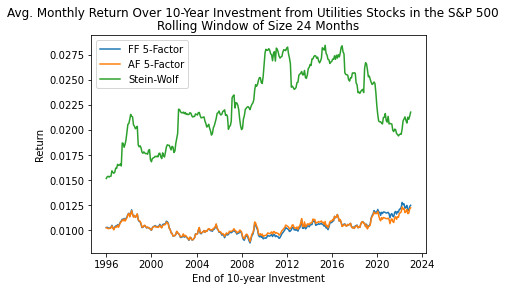

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.010031,0.010008,0.019977,0.007522,0.006421
OSR,0.295535,0.296219,0.549213,0.183563,0.163688


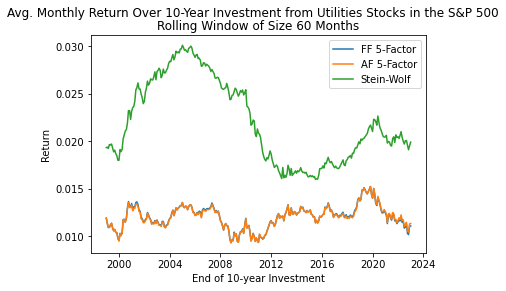

In [94]:
# ff 5-factor w/o BM
compare_FF_devil(['MKT','SMB','RMW','CMA'], 10, 0, 0, 0.0117)

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009576,0.009389,0.009356,0.007361,0.007252
OSR,2.737160,2.630441,2.697968,0.181855,0.250459


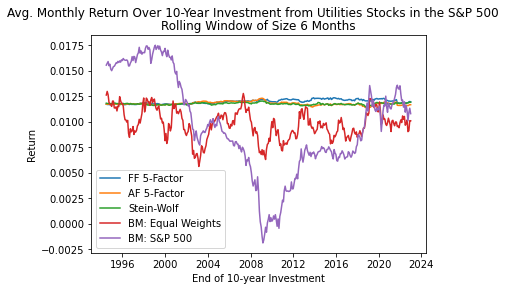

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009661,0.009679,0.009666,0.007358,0.007188
OSR,0.954750,0.950140,1.602700,0.181720,0.237584


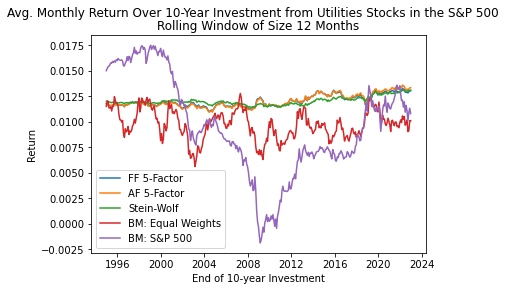

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.008320,0.008258,0.020159,0.007368,0.007045
OSR,0.477850,0.473524,0.496313,0.181807,0.215965


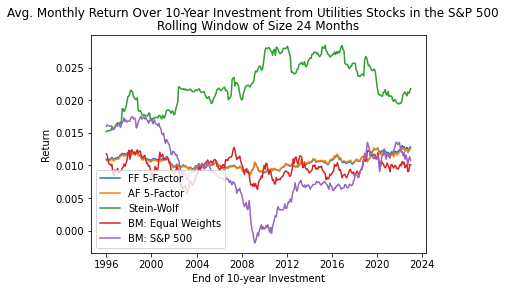

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.010208,0.010218,0.019977,0.007522,0.006421
OSR,0.306804,0.305404,0.549213,0.183563,0.163688


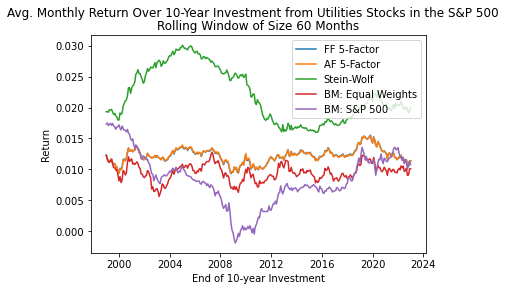

In [95]:
# aqr 5-factor with BM
compare_FF_devil(['MKT','SMB','MOM','STR'], 10, 1, 1, 0.0117)

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009576,0.009389,0.009356,0.007361,0.007252
OSR,2.737160,2.630441,2.697968,0.181855,0.250459


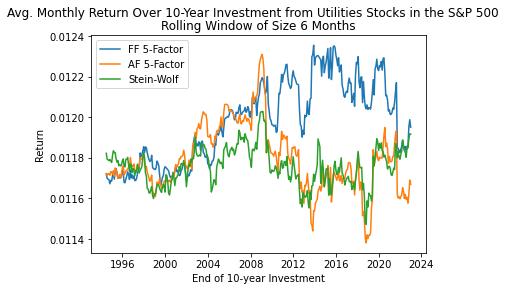

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009661,0.009679,0.009666,0.007358,0.007188
OSR,0.954750,0.950140,1.602700,0.181720,0.237584


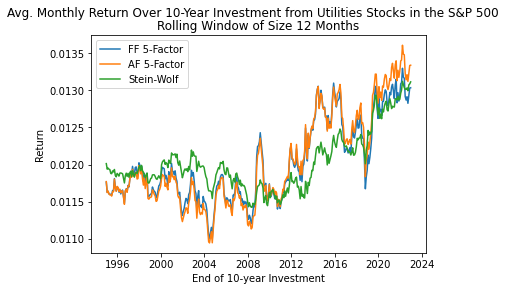

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.008320,0.008258,0.020159,0.007368,0.007045
OSR,0.477850,0.473524,0.496313,0.181807,0.215965


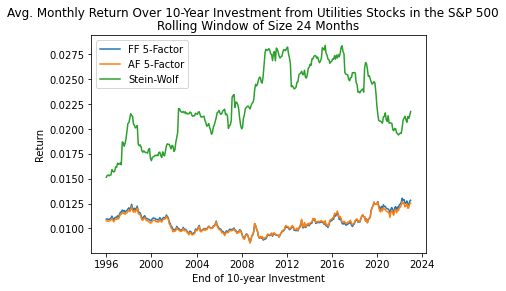

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.010208,0.010218,0.019977,0.007522,0.006421
OSR,0.306804,0.305404,0.549213,0.183563,0.163688


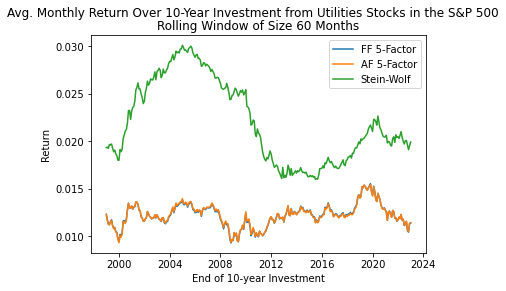

In [96]:
# aqr 5-factor w/o BM
compare_FF_devil(['MKT','SMB','MOM','STR'], 10, 0, 0, 0.0117)

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009558,0.009295,0.009356,0.007361,0.007252
OSR,4.905981,6.538625,2.697968,0.181855,0.250459


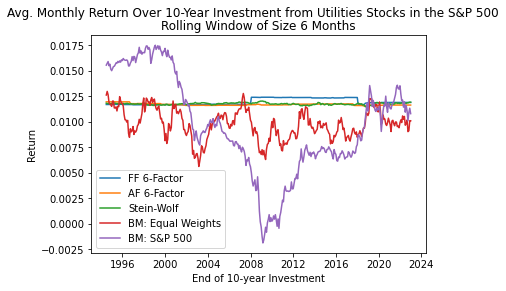

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009366,0.009340,0.009666,0.007358,0.007188
OSR,0.984237,0.985457,1.602700,0.181720,0.237584


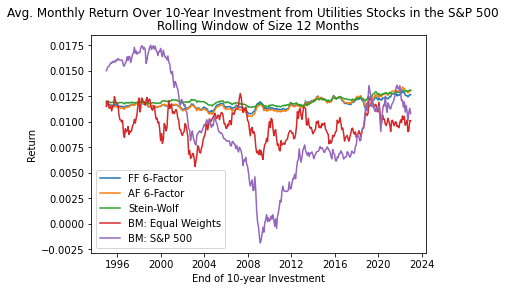

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.008454,0.008418,0.020159,0.007368,0.007045
OSR,0.513685,0.511048,0.496313,0.181807,0.215965


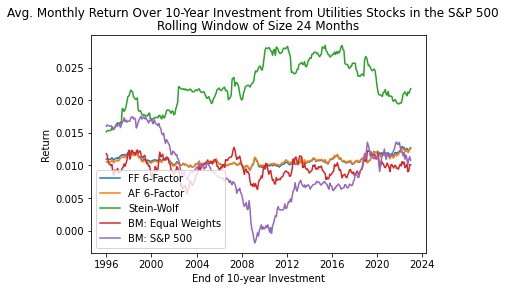

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.010269,0.010262,0.019977,0.007522,0.006421
OSR,0.312035,0.313219,0.549213,0.183563,0.163688


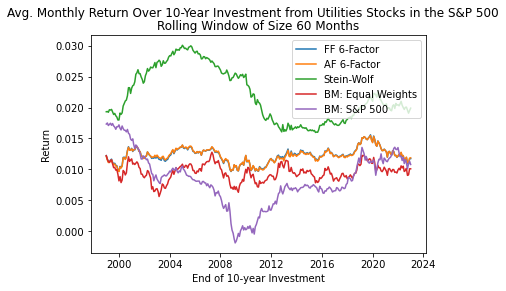

In [97]:
# 6-factor with BM
compare_FF_devil(['MKT','SMB','RMW','CMA','MOM'], 10, 1, 1, 0.0117)

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009558,0.009295,0.009356,0.007361,0.007252
OSR,4.905981,6.538625,2.697968,0.181855,0.250459


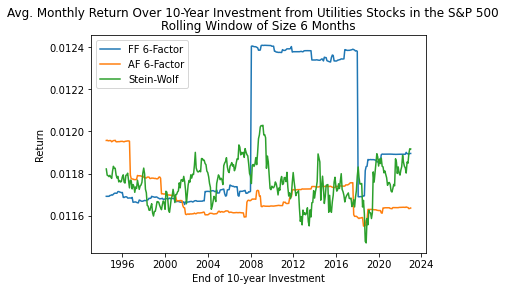

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.009366,0.009340,0.009666,0.007358,0.007188
OSR,0.984237,0.985457,1.602700,0.181720,0.237584


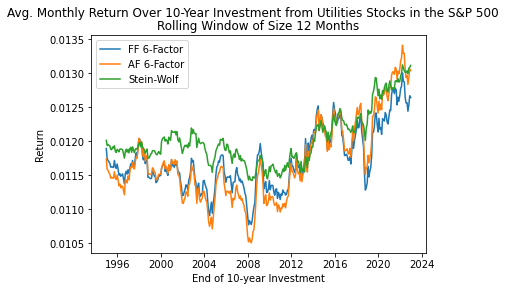

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.008454,0.008418,0.020159,0.007368,0.007045
OSR,0.513685,0.511048,0.496313,0.181807,0.215965


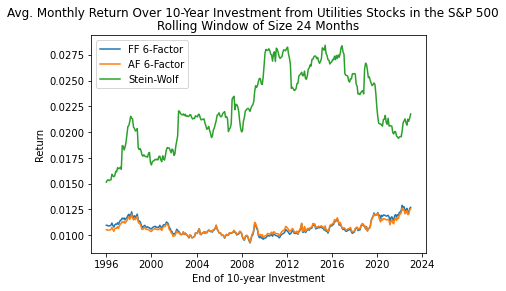

,FF,AF,Stein-Wolf,Equal Weights,S&P 500
ORTN,0.010269,0.010262,0.019977,0.007522,0.006421
OSR,0.312035,0.313219,0.549213,0.183563,0.163688


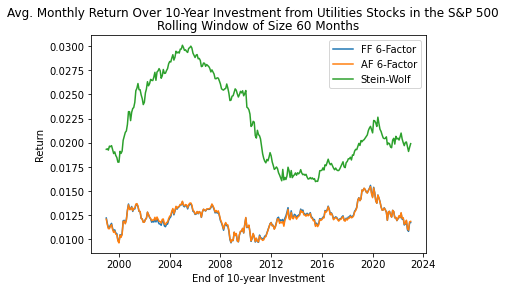

In [98]:
# 6-factor w/o BM
compare_FF_devil(['MKT','SMB','RMW','CMA','MOM'], 10, 0, 0, 0.0117)

# Things to Look into:

1. Devil vs FF performance in 3 factor
2. Devil vs FF performance in 5 factor (use FF data for all 4 factors and just swap in devil vs not devil)
3. Devil vs FF performance in 6 factor (5 factor with momentum factor)
4. What is a good rolling window to use for calculation? 5 years back? 2 years? 1 year? how does our window choice affect returns? What is the optimal Window?
    * What does this say on how long the market stays constant for?


# Needed from code perspective:
* Overall loop to set lookback and run rolling window
* Data for 5 and 6 factor models
* Returns calculation given allocation provided by `factorModel`
* Performance Metrics 